In [755]:
# This notebook implements bilinear interpolation to locate image nodes after mesh morphing

In [756]:
import numpy as np
from matplotlib import pyplot as plt

In [757]:
# Nomenclature
# "datum"   = geometry-defining point in mesh, required at any discontinuity in contour (e.g. corner, change in curvature). Datum positions define the transformation and must be specified for both the original and image mesh
# "node"    = non geometry-defining point in mesh. Node positions defined in original mesh are interpolated to image mesh based on image datum positions.

# A,B,C     = column position vector representing some fixed point reference (in the scope of the method)
# u,v,w     = column direction vector, typically representing the vector between two points
# x,y,z     = unit column direction vectors (bases) corresponding to each coordinate dimension
# a,b,c     = unit column direction vectors (bases) corresponding to each local reference frame dimension
# p,q       = column position vector representing a variable point of interest
# r,d       = some variable vector property (e.g. scaling parameter, distance, etc)

In [758]:
# Define common vector operations
def d(A, B):
    '''Euclidean measure function'''
    return np.linalg.norm(A - B)

def intersection(A, B, u, v):
    '''solve C = A + su = Bx + tv
    '''
    M = np.hstack((v,-u))
    # singular matrix then A = B = C
    if np.linalg.det(M) == 0:
        return A
    else:
        M_inv = np.linalg.inv(M)
        params = np.matmul(M_inv, np.subtract(A,B))
        return A + params[1]*u


In [759]:
# Define homogenous functions to be used with matrix-form transformations
def h(v):
    '''return the homogenous form of 2D vector v'''
    if len(np.shape(v)) == 2 and np.shape(v)[0] == 2:
        return np.vstack([v, np.ones(np.shape(v)[1])])
    else:
        raise ValueError("Input to homogenous function must be 2D.")

def f(h):
    '''return the Euclidean form of 3D homogenous vector h'''
    if len(np.shape(h)) == 2 and np.shape(h)[0] == 3:
        return h[0:2,:]
    else:
        raise ValueError("Input to homogenous function must be 3D.")

In [760]:
# Define common matrix-form transformation operations
def R(theta, unit):
    '''2D rotation matrix defining a CCW rotation about the origin by angle theta'''
    # convert to radians for numpy trig functions
    if unit == "deg":
        theta *= np.pi/180
    elif unit == "rad":
        pass
    else:
        raise ValueError("Unit must be 'deg' or 'rad'.")
    
    return np.array([[np.cos(theta), -np.sin(theta), 0],
                     [np.sin(theta),  np.cos(theta), 0],
                     [            0,              0, 1]
                   ])

def T(delta_x, delta_y):
    '''2D translation matrix defining an offset <delta_x, delta_y>'''
    return np.array([[1, 0, delta_x],
                     [0, 1, delta_y],
                     [0, 0, 1]
                   ])

def frame(p, A, theta, unit):
    '''represent point p in new reference frame located at A and rotated by angle theta'''
    Tm = T(-A[0,0], -A[1,0])
    Rm = R(theta, unit)

    return f(np.matmul(np.matmul(Rm, Tm), h(p)))

In [761]:
class Mesh:
    def __init__(self, pts_x, pts_y, theta=30, unit="deg"):
        # initialize datums defining mesh geometry
        if len(pts_x) == len(pts_y):
            self.num_pts = len(pts_x)
            self.datums = np.array([pts_x, pts_y])
        else:
            raise ValueError("Length of pts_x and pts_y must be the same.")
        
        # initialize empty mesh
        self.num_nds = 0
        self.nodes = None
        self.r_list = None
        self.dat_list = None
        
        # initialize arbitrary offset angle for ensuring deltas
        self.theta = 30
        self.unit = "deg"
    
    def plot_mesh(self, show_nodes=False):
        '''Plot the Mesh object in Euclidean space'''
        plt.scatter(x=self.datums[0], y=self.datums[1], s=50, marker='o')
        if show_nodes:
            if self.nodes.any():
                plt.scatter(x=self.nodes[0], y=self.nodes[1], s=10, marker='D')
            else:
                raise ValueError("No nodes defined.")
            
        plt.show()
        
    def def_nodes(self, nds_x, nds_y):
        '''Add nodes to Mesh object, overwrite if already existing'''
        if len(nds_x) == len(nds_y):
            self.num_nds = len(nds_x)
            self.nodes = np.array([nds_x, nds_y])
            self.r_list = np.zeros([self.num_nds,3,2])
            self.dat_list = self.num_pts * np.ones([self.num_nds,4])
        else:
            raise ValueError("Length of nds_x and nds_y must be the same.")
    
    def m(self,i):
        '''Shorthand to represent the ith datum'''
        return self.datums[:,i].reshape(-1,1)

    def dat_at_pt(self, A):
        '''Get the datum index at a certain point if exists
        If not exists, return number of datums (i.e. known invalid index)'''
        mask = np.all(np.isclose(self.datums, A), axis=0)
        if mask.any():
            return np.argmax(np.all(np.isclose(self.datums, A), axis=0))
        else:
            return self.num_pts
    
    def n(self,i):
        '''Shorthand to represent the ith node'''
        if self.nodes is None:
            raise ValueError("No nodes defined.")
        else:
            return self.nodes[:,i].reshape(-1,1)
    
    def pop_closest_pt(self, p, A_list):
        min_dist = np.inf
        min_pt = None
        for i in range(len(A_list[0])):
            A = A_list[:, i].reshape(-1,1)
            dist = d(p, A)
            if dist < min_dist:
                min_dist = dist
                min_pt = i

        return A_list[:,min_pt].reshape(-1,1), np.delete(A_list, min_pt, axis=1)
    
    def calc_r(self, p, A1, A2, A3, A4):
        '''Calculate bilinear interpolation ratio for p and datums A1, A2, A3, A4
        See: https://en.wikipedia.org/wiki/Bilinear_interpolation
        '''
        y = np.array([[0],[1]])
        B1 = intersection(p, A1, y, A2-A1)
        B2 = intersection(p, A3, y, A4-A3)

        with np.errstate(divide='ignore', invalid='ignore'):
            r_a = np.nan_to_num(frame(B1, A1, self.theta, self.unit) / frame(A2, A1, self.theta, self.unit))
            r_b = np.nan_to_num(frame(B2, A3, self.theta, self.unit) / frame(A4, A3, self.theta, self.unit))
            r_c = np.nan_to_num(frame(p,  B1, self.theta, self.unit) / frame(B2, B1, self.theta, self.unit))
        
        return r_a, r_b, r_c
    
    def fill_r_list(self):
        for nd in range(self.num_nds):
            p = self.n(nd)
            A1, dats_remaining = self.pop_closest_pt(p, self.datums)
            A2, dats_remaining = self.pop_closest_pt(p, dats_remaining)
            A3, dats_remaining = self.pop_closest_pt(p, dats_remaining)
            A4, dats_remaining = self.pop_closest_pt(p, dats_remaining)

            self.r_list[nd] = np.vstack(self.calc_r(p, A1, A2, A3, A4)).reshape(3, 2)
            self.dat_list[nd] = [self.dat_at_pt(A1), self.dat_at_pt(A2), self.dat_at_pt(A3), self.dat_at_pt(A4)]

    def gen_mesh(self, orig_mesh):
        self.num_nds = orig_mesh.num_nds
        self.nodes = np.zeros([2,self.num_nds])
    
        for nd in range(self.num_nds):
            # extract node info from template mesh
            A1, A2, A3, A4 = orig_mesh.dat_list[nd].astype(int)
            r_a, r_b, r_c = orig_mesh.r_list[nd]

            B1 = np.multiply(r_a.reshape(-1,1), self.m(A1) + self.m(A2))
            B2 = np.multiply(r_b.reshape(-1,1), self.m(A3) + self.m(A4))
            self.nodes[:,nd] = np.multiply(r_c.reshape(-1,1), B1 + B2).ravel()


In [762]:
pts_x = [0,1,1,0]
pts_y = [0,0,1,1]
square = Mesh(pts_x, pts_y)
# square.plot_mesh()

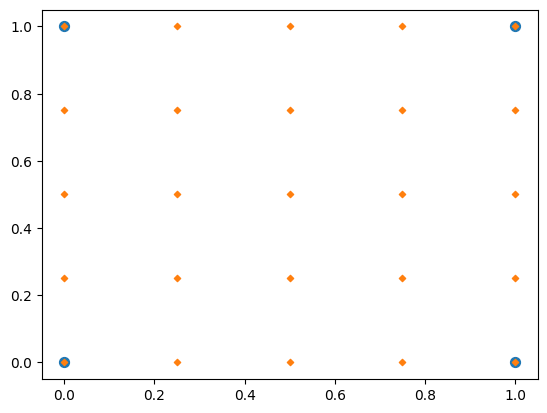

In [763]:
nds_x = [0.00,0.25,0.50,0.75,1.00, 0.00,0.25,0.50,0.75,1.00, 0.00,0.25,0.50,0.75,1.00, 0.00,0.25,0.50,0.75,1.00, 0.00,0.25,0.50,0.75,1.00]
nds_y = [0.00,0.00,0.00,0.00,0.00, 0.25,0.25,0.25,0.25,0.25, 0.50,0.50,0.50,0.50,0.50, 0.75,0.75,0.75,0.75,0.75, 1.00,1.00,1.00,1.00,1.00]

square.def_nodes(nds_x, nds_y)
square.fill_r_list()

square.plot_mesh(show_nodes=True)

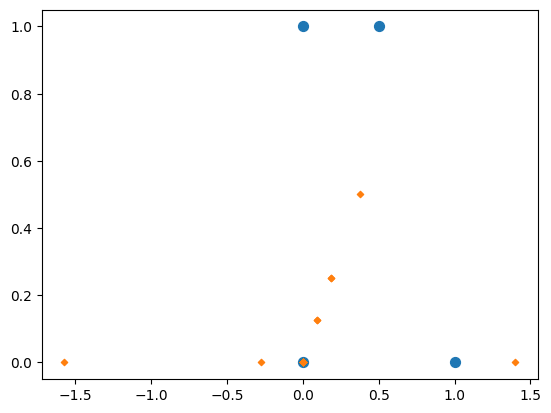

In [764]:
pts_x = [0,1,0.5,0]
pts_y = [0,0,1,1]
trapezoid = Mesh(pts_x, pts_y)

trapezoid.gen_mesh(square)
trapezoid.plot_mesh(show_nodes=True)